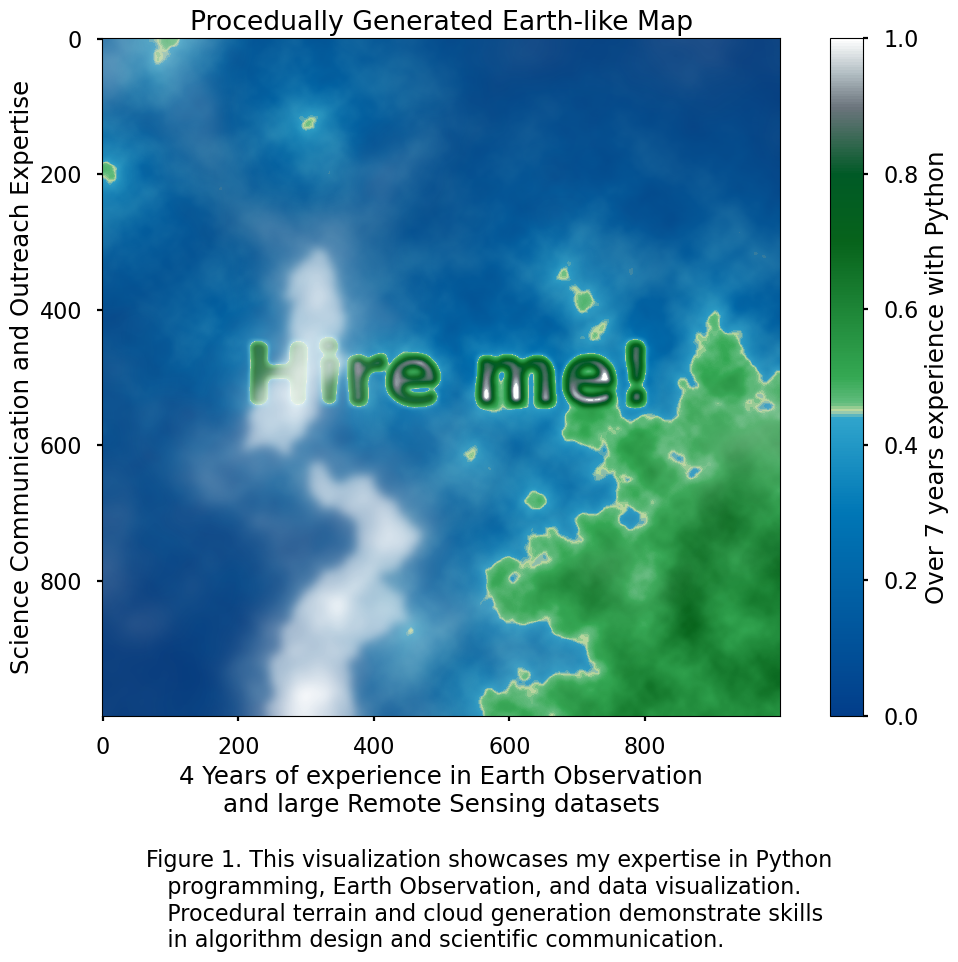

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, gaussian_filter, distance_transform_edt
from scipy.signal import convolve2d
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

plt.style.use('seaborn-poster')

# Resize an image using cubic interpolation (order 3)
resize_image = lambda image, new_size: zoom(image, (new_size[0] / image.shape[0], 
                                                    new_size[1] / image.shape[1]), order=3)

# Normalise an image to 0 - 1 range
normalise = lambda image: (image - np.min(image)) / (np.max(image) - np.min(image))

def create_text_as_array(text="Hire me!", fontsize=90, figsize=(10, 10)):
    """Render text as Numpy array. The size of the array depends on the figsize parameter.

    Parameters:
    text (str): The text to render as an array.
    fontsize (int): Font size for the text.
    figsize (tuple): The size of the figure in inches.

    Returns:
    numpy.ndarray: A binary array representing the rendered text.
    """

    # Create a figure and render the text
    fig, ax = plt.subplots(figsize=figsize)
    ax.text(0.5, 0.5, text, color='black', fontsize=fontsize, ha='center', va='center', weight='bold')
    ax.axis("off")
    fig.canvas.draw()  # Render the text to the canvas

    # Convert the rendered text to a Numpy array
    text_as_array = np.array(fig.canvas.renderer.buffer_rgba())[:, :, 0] < 0.5
    
    # Use a convolution to make the text more blurry and 'rough' around the edges (more like a coastline). 
    conv_arr = np.random.rand(15, 15)
    text_as_array = convolve2d(text_as_array.astype(float), conv_arr/np.sum(conv_arr), mode='same')
    
    plt.close(fig)

    text_as_array = normalise(text_as_array.astype(float))

    return text_as_array

def generate_map(map_size = 1000, start_point = 0, extra_layers=[], text="Hire me!"):
    """Simulate terrain. Generates a map by combining layers of noise and text.
    The map gen is adapted from https://github.com/eric-robertson/fantasy-map-gen
    Relates to Perlin noise. 

    Parameters:
    map_size (int): The size of the generated map.
    start_point (int): The starting point for generating layers of noise.
    extra_layers (list): Additional layers to include in the terrain.
    text (str): Text to include in the map.

    Returns:
    numpy.ndarray: The generated terrain map.
    """

    _ranges = list(range(start_point, int(map_size/100)))
    _ranges.extend(extra_layers)
    
    # Create the text and resize ready for the map
    if len(text) > 0:
        text_as_array = create_text_as_array(text)
        a = resize_image(text_as_array, (map_size, map_size)) * 0.2
    else:
        a = np.zeros((map_size, map_size))

    # Creating layers of varying 'noise' levels & adding each one to the map.
    # This process is the essence of making the map look like actual terrain. 
    for layer in _ranges:
        l = 2**layer
        rand = np.random.rand(l,l) /l
        a += resize_image(rand, (map_size,map_size))   

    map = normalise(a)

    map = gaussian_filter(map, 2)

    return map

def generate_clouds(map_size, cloud_size = 2, cloud_threshold = 0.8, cloud_smoothing = 2, text="Hello!"):
    """Generate clouds by smoothing random noise.

    Parameters:
    map_size (int): Size of one dimension of the output clouds array.
    cloud_size (int): Controls the size of the clouds. 0 - 9 with 9 being small clouds.
    cloud_threshold (float): Minimum value for clouds.
    cloud_smoothing (float): Controls the smoothing. Higher results in more diffuse clouds.

    Returns:
    numpy.ndarray: Generated cloud array.
    """
    clouds = generate_map(map_size=map_size, start_point=cloud_size, extra_layers=[], text="")
    text_mask = gaussian_filter(create_text_as_array(text), 2)
    # clouds = np.where(text_mask == 0, clouds, clouds**2) # Avoids clouds over the text
    clouds = np.where(clouds < cloud_threshold, clouds**2, clouds)
    clouds = gaussian_filter(clouds, cloud_smoothing)
    
    return clouds

# Parameters for the map and clouds
map_size = 1000
cloud_size, cloud_threshold, cloud_smoothing = 2, 0.8, 7

# Create a colormap for the Earth and clouds
# Colours were taken from a Sentinel-2 image of the Earth
earth_colors = [(0.0, "#023E8A"), (0.3, "#0077B6"), (0.44, "#30a5cc"), 
          (0.45, "#c3daa2"), (0.46, "#63bd7f"), (0.5, "#34A853"), 
          (0.7, "#07631B"), (0.8, "#005a26"), (0.9, "#6C757D"), (0.95, "#B2BEC3"), (1.0, "white")]

earth_cmap = LinearSegmentedColormap.from_list("earth_colormap", earth_colors)
cloud_cmap = LinearSegmentedColormap.from_list("cloud_colormap", [(0.0, "#9C9C9C"), (0.5, "#DBDBDB"), (1.0, "white")])

very_important_text = "Hire me!"

# Generate the map and clouds
map = generate_map(map_size=map_size, start_point=4, extra_layers=[1], text=very_important_text)

snow_level = 0.95
map = np.where(map > snow_level, 1.0, map)

clouds = generate_clouds(map_size=map_size, cloud_size=cloud_size, cloud_threshold=cloud_threshold, cloud_smoothing=cloud_smoothing, text=very_important_text)

# Make a layer for the ocean so it looks a deeper blue further away from the coast
ocean = np.ones(map.shape)*0.05
dist_from_coast = normalise(distance_transform_edt(map < 0.45))

##########################
#### Plotting the map ####
##########################
fig, ax = plt.subplots()

# Plot the map and overlay the clouds using alpha blending
p = ax.imshow(map, cmap=earth_cmap, vmax=1, vmin=0)
ax.imshow(ocean, cmap="Blues_r", alpha=dist_from_coast**0.5, vmin=0, vmax=1)
ax.imshow(clouds, cmap=cloud_cmap, alpha=clouds**2) 
# Colorbar for completeness (though it is meaningless here)
cbar = plt.colorbar(p, ax=ax)

########################################################################
#### Plot formatting and some short reasons why you should hire me: ####
########################################################################
ax.set_title("Procedually Generated Earth-like Map")
ax.set_xlabel("4 Years of experience in Earth Observation\nand large Remote Sensing datasets")
ax.set_ylabel("Science Communication and Outreach Expertise")
cbar.ax.set_ylabel("Over 7 years experience with Python")

fig.text(0.25, -0.1, 
         "Figure 1. This visualization showcases my expertise in Python\n   programming, Earth Observation, and data visualization.\n"
         "   Procedural terrain and cloud generation demonstrate skills\n   in algorithm design and scientific communication.",
         fontsize=16, ha='left', va='center')

fig.savefig("Hire_me.png", dpi=300, bbox_inches='tight')

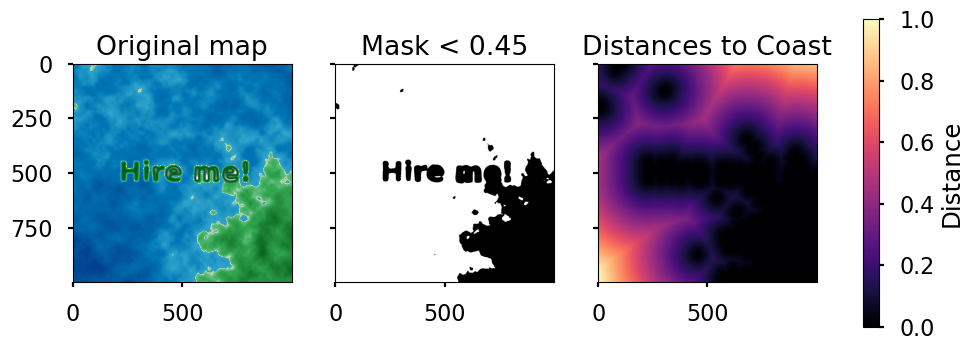

<Figure size 1280x880 with 0 Axes>

In [32]:
#### For finding the distance to the nearest coastline ####
# Compute Euclidean distance to the nearest '0.45' element using distance transform. 
# 0.45 is the threshold for the beaches (from the defined colour scale). 
mask = map < 0.45
distances = normalise(distance_transform_edt(mask))  


fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
ax[0].imshow(map, cmap=earth_cmap)
ax[0].set_title("Original map")
ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Mask < 0.45")
im = ax[2].imshow(distances, cmap='magma')
ax[2].set_title("Distances to Coast")
fig.colorbar(im, ax=ax).ax.set_ylabel("Distance")
plt.show()

plt.tight_layout()
